# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import importlib
from collections import deque
import matplotlib.pyplot as plt
import torch


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis.app")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step      
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```


Idea 1:
* Use 2 individual actor-critic agents. 
* Use a critic (value estimation function) that takes only a current agent's state to estimate.
* Use an actor that accepts an individual agent's state, as well as each of it's opponents states to output the corresponding action that should be performed.

Idea 2 (From group):
* Frame the problem as a 'self-play' problem. Each agent recieves it's own **local** observation, so we can train 1 agent to accept both observations and to generate an output.
* Share the same actor network and DON'T condition on other agent states. (May need to condition on other agent states for collaborative actions when using only the actor model. If so, the agent must have visibility into the other agent's position. If we don't need it, then perhaps the agent's policys implicitly understand where their partner will likely move given the Q-value function was shared and had full visibility while learning).
* Share the same critic network, but use a 'state_set' that conditions estimates of Q(s', state_set, a) on model parameters AND the shared set of states of all agents in the network.
    * After initial implementation, it was observed that no learning (or slow learning given the right exploration parameters were set) occured in this methodology. One potential reason for this is that the states are environment states and not agent states. So adding a 'state_set' is not enough to collaboratively share information. Rather, as proposed in the MARL paper, we can instead condition the Q function to instead work by conditioning on a set of actions so that Q is Q(s', a1, a2, ..., an) -> value of action i.


Future ideas:
* Frame the learning as a horizontally symmetric set of states, and attempt to 'Double Up' on the effective learning for both agents by augmenting their training datasets to improve sample efficiency and to increase the rate of learning.




In [43]:
%%writefile model.py

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, num_agents, seed, fcs1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            num_agents (int): Number of agents in the environment.
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
            
            Input is: [Scurrent, [S0, S1, ..., 0, ..., Sl], action]
            NOTE: [S0, S1, ..., 0, ..., Sl] is a set of state matricies hstacked into a single matrix.
            
        """
        super(Critic, self).__init__()
        self.num_agents = num_agents
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size + state_size*num_agents, fcs1_units)
        self.bn1 = nn.BatchNorm1d(num_features=fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, state_set, action):
        """Build a critic (value) network that maps (state, states, action) pairs -> Q-values."""
        xs = torch.cat((state, state_set), dim=1)
        xs = F.leaky_relu(self.fcs1(xs))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)



Overwriting model.py


In [44]:
# %%writefile ddpg_agent.py

# import numpy as np
# import random
# import copy
# from collections import namedtuple, deque

# from model import Actor, Critic

# import torch
# import torch.nn.functional as F
# import torch.optim as optim

# BUFFER_SIZE = int(1e6)  # replay buffer size
# BATCH_SIZE = 128        # minibatch size
# GAMMA = 0.99            # discount factor
# TAU = 1e-3              # for soft update of target parameters
# LR_ACTOR = 1e-4         # learning rate of the actor 
# LR_CRITIC = 1e-4        # learning rate of the critic
# WEIGHT_DECAY = 0 #0.0001   # L2 weight decay
# EPSILON = 1.0           # explore->exploit noise process added to act step
# # EPSILON_DECAY = 1e-6    # decay rate for noise process
# EPSILON_DECAY = 0.9999

# UPDATE_TIMES = 10 # Update the network this many times when the learn function is called.
# STEPS_TO_UPDATE = 20 # Call the learn function 'UPDATE_TIMES' every 'STEPS_TO_UPDATE'

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# class Agent():
#     """Interacts with and learns from the environment."""
    
#     def __init__(self, state_size, action_size, random_seed):
#         """Initialize an Agent object.
        
#         Params
#         ======
#             state_size (int): dimension of each state
#             action_size (int): dimension of each action
#             random_seed (int): random seed
#         """
#         self.steps = 0
        
#         self.state_size = state_size
#         self.action_size = action_size
#         self.seed = random.seed(random_seed)
#         self.epsilon = EPSILON
        
#         # Actor Network (w/ Target Network)
#         self.actor_local = Actor(state_size, action_size, random_seed).to(device)
#         self.actor_target = Actor(state_size, action_size, random_seed).to(device)
#         self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

#         # Critic Network (w/ Target Network)
#         self.critic_local = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_target = Critic(state_size, action_size, random_seed).to(device)
#         self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

#         # Noise process
#         self.noise = OUNoise(action_size, random_seed)

#         # Replay memory
#         self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
#     def step(self, state, action, reward, next_state, done):
#         """Save experience in replay memory, and use random sample from buffer to learn."""
#         # Save experience / reward
#         self.memory.add(state, action, reward, next_state, done)

#         # Increment step counter.
#         self.steps += 1
        
#         # Learn, if enough samples are available in memory
#         if len(self.memory) > BATCH_SIZE and self.steps % STEPS_TO_UPDATE == 0:
#             for i in range(UPDATE_TIMES):
#                 experiences = self.memory.sample()
#                 self.learn(experiences, GAMMA)

#     def act(self, state, add_noise=True):
#         """Returns actions for given state as per current policy."""
#         state = torch.from_numpy(state).float().to(device)
#         self.actor_local.eval()
#         with torch.no_grad():
#             action = self.actor_local(state).cpu().data.numpy()
#         self.actor_local.train()
#         if add_noise:
#             action += self.epsilon * self.noise.sample()
#         return np.clip(action, -1, 1)

#     def reset(self):
#         self.noise.reset()

#     def learn(self, experiences, gamma):
#         """Update policy and value parameters using given batch of experience tuples.
#         Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
#         where:
#             actor_target(state) -> action
#             critic_target(state, action) -> Q-value

#         Params
#         ======
#             experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
#             gamma (float): discount factor
#         """
#         states, actions, rewards, next_states, dones = experiences

#         # ---------------------------- update critic ---------------------------- #
#         # Get predicted next-state actions and Q values from target models
#         actions_next = self.actor_target(next_states)
#         Q_targets_next = self.critic_target(next_states, actions_next)
#         # Compute Q targets for current states (y_i)
#         Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
#         # Compute critic loss
#         Q_expected = self.critic_local(states, actions)
#         critic_loss = F.mse_loss(Q_expected, Q_targets)
#         # Minimize the loss
#         self.critic_optimizer.zero_grad()
#         critic_loss.backward()
#         torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
#         self.critic_optimizer.step()

#         # ---------------------------- update actor ---------------------------- #
#         # Compute actor loss
#         actions_pred = self.actor_local(states)
#         actor_loss = -self.critic_local(states, actions_pred).mean()
#         # Minimize the loss
#         self.actor_optimizer.zero_grad()
#         actor_loss.backward()
#         self.actor_optimizer.step()

#         # ----------------------- update target networks ----------------------- #
#         self.soft_update(self.critic_local, self.critic_target, TAU)
#         self.soft_update(self.actor_local, self.actor_target, TAU)

#         # Decay noise and reset.
#         # self.epsilon -= EPSILON_DECAY
#         self.epsilon = self.epsilon * EPSILON_DECAY
#         # self.noise.reset()

#     def soft_update(self, local_model, target_model, tau):
#         """Soft update model parameters.
#         θ_target = τ*θ_local + (1 - τ)*θ_target

#         Params
#         ======
#             local_model: PyTorch model (weights will be copied from)
#             target_model: PyTorch model (weights will be copied to)
#             tau (float): interpolation parameter 
#         """
#         for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
#             target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# class OUNoise:
#     """Ornstein-Uhlenbeck process."""

#     def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
#         """Initialize parameters and noise process."""
#         self.mu = mu * np.ones(size)
#         self.theta = theta
#         self.sigma = sigma
#         self.seed = random.seed(seed)
#         self.reset()

#     def reset(self):
#         """Reset the internal state (= noise) to mean (mu)."""
#         self.state = copy.copy(self.mu)

#     def sample(self):
#         """Update internal state and return it as a noise sample."""
#         x = self.state
#         dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
#         self.state = x + dx
#         return self.state

# class ReplayBuffer:
#     """Fixed-size buffer to store experience tuples."""

#     def __init__(self, action_size, buffer_size, batch_size, seed):
#         """Initialize a ReplayBuffer object.
#         Params
#         ======
#             buffer_size (int): maximum size of buffer
#             batch_size (int): size of each training batch
#         """
#         self.action_size = action_size
#         self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
#         self.batch_size = batch_size
#         self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         self.seed = random.seed(seed)
    
#     def add(self, state, action, reward, next_state, done):
#         """Add a new experience to memory."""
#         e = self.experience(state, action, reward, next_state, done)
#         self.memory.append(e)
    
#     def sample(self):
#         """Randomly sample a batch of experiences from memory."""
#         experiences = random.sample(self.memory, k=self.batch_size)

#         states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
#         actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
#         rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
#         next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
#         dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

#         return (states, actions, rewards, next_states, dones)

#     def __len__(self):
#         """Return the current size of internal memory."""
#         return len(self.memory)



In [50]:
%%writefile ddpg_agents.py

import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0 #0.0001   # L2 weight decay
EPSILON = 1.0           # explore->exploit noise process added to act step
# EPSILON_DECAY = 1e-6    # decay rate for noise process
EPSILON_DECAY = 1 #0.9999

UPDATE_TIMES = 2 # Update the network this many times when the learn function is called.
STEPS_TO_UPDATE = 1 # Call the learn function 'UPDATE_TIMES' every 'STEPS_TO_UPDATE'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agents():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        
        
        ''' 
        TODO: 
        1. Set up 'N' agents, each with their own local, target, optimizers.
        2. All agents use the same actor network, but it is conditioned on the state of all actors.
        3. All agents use a shared critic network, but the critic network estimates the collective 
        value of all states of all agents.
        
        '''
        
        # Set up the shared hyperparameters among all agents.
        self.steps = 0
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.epsilon = EPSILON
        
        # Set up the actor and critic networks
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size,  num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, state_set, action, reward, next_state, done):
        
        ''' 
        TODO: 
        1. Each tuple added to the memory will now be (state, state set w/state zero'd , action, reward, next_state, done)
        '''
        
        
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, state_set, action, reward, next_state, done)

        # Increment step counter.
        self.steps += 1
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.steps % STEPS_TO_UPDATE == 0:
            for i in range(UPDATE_TIMES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        ''' 
        TODO: 
        1. Set up 'N' agents, each with their own local, target, optimizers.
        2. All agents use the same actor network, but it is conditioned on the state of all actors.
        3. All agents use a shared critic network, but the critic network estimates the collective 
        value of all states of all agents.
        
        Update the learning estimates so that the agents 
        
        '''
        
        
        
        states, state_sets, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        
#         import pdb; pdb.set_trace()
        
        Q_targets_next = self.critic_target(next_states, state_sets, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, state_sets, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, state_sets, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

        # Decay noise and reset.
        # self.epsilon -= EPSILON_DECAY
        self.epsilon = self.epsilon * EPSILON_DECAY
        # self.noise.reset()

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.3):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "state_set", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, state_set, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, state_set, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        state_sets = torch.from_numpy(np.vstack([e.state_set for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, state_sets, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)





Overwriting ddpg_agents.py


In [51]:
# import ddpg_agent
# importlib.reload(ddpg_agent)

import ddpg_agents
importlib.reload(ddpg_agents)
# import model
# importlib.reload(model)


<module 'ddpg_agents' from '/Users/dagriff2/Documents/Playground/Reinforcement_Learning/RL-Course-Projects/p3_collab-compet/ddpg_agents.py'>

In [52]:
agents = ddpg_agents.Agents(state_size=env_info.vector_observations[0].shape[0],
                            action_size=brain.vector_action_space_size,
                            num_agents=2,
                            random_seed=10)


/Users/dagriff2/.pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 10	Average Score: -0.00
Episode 20	Average Score: -0.00
Episode 30	Average Score: 0.00
Episode 40	Average Score: -0.00
Episode 50	Average Score: -0.00
Episode 60	Average Score: -0.00
Episode 70	Average Score: -0.00
Episode 80	Average Score: -0.00
Episode 90	Average Score: -0.00
Episode 100	Average Score: -0.00


[]

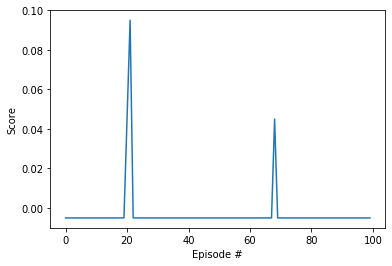

In [53]:

def ddpg(n_episodes=100, max_t=1000):
    scores_deque = deque(maxlen=100)
    max_score = -np.Inf
    scores_list = []
    for i_episode in range(1, n_episodes+1):
        # Reset the agent's state.
        env_info = env.reset(train_mode=True)[brain_name]
        # Get the current state.
        states = env_info.vector_observations
        # Reset the agent's noise parameter.
        agents.reset()
        scores = np.zeros(num_agents)
        # For each time step in episode, get action, act, and learn.
        for t in range(max_t):
            actions = agents.act(states, add_noise=True)        # select an action
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            
            # Generate the state_set context matrix for each agent.
            state_sets = []
            for i in range(num_agents):
                # Copy all states.
                tstate_set = states.copy()
                # Zero out the current agent's state matrix in state set.
                tstate_set[i] = np.zeros(states[0].shape)
                # Ravel the matrix and add it to the list of state sets.
                state_sets.append(tstate_set.ravel())
                
            # For each tuple, have the agents MARL system take a step.
            for state, state_set, action, reward, next_state, done in zip(states, state_sets, actions, rewards, next_states, dones):
                agents.step(state, state_set, action, reward, next_state, done)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        # Add final score to the scores queue.
        score = np.mean(scores)
        scores_deque.append(score)
        scores_list.append(score)

#         with open('scores_list.txt', 'a') as f:
#             f.write("{}\n".format(score))
#         print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        
        # If performance goal reached, store final checkpoints.
        if len(scores_deque) >= 100 and np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agents.actor_local.state_dict(), 'final_checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'final_checkpoint_critic.pth')
            break

        # Output progress every 10 episodes
        if i_episode % 10 == 0:
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            with open('progress.txt', 'a') as f:
                f.write('\n\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores_list

# Run ddpg algorithm, and save final output.
scores = ddpg()
torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')

# Plot performance
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('performance.png')
plt.plot()
